# 🚗 Lecture Demo: Used Cars Price Prediction

<img src="img/used_car_meme.jpeg" alt= “spam-email” width="250" />

In [2]:
# Load in additional functions
library(tidyverse)
library(lubridate)

install.packages("randomForest")
library(randomForest)

# Use three digits past the decimal point,
# and don't use scientific notation.
options(digits = 3, scipen = 999)

# Format plots with a white background and dark features.
theme_set(theme_bw())

# Increase the default text size of plots.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
theme_update(text = element_text(size = 20))

# Increase the default plot width and height.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
options(repr.plot.width=12, repr.plot.height=8)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.1.2"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message in readRDS(dest):
"lzma decoder corrupt data"



The downloaded binary packages are in
	/var/folders/ty/g5x2zyjs7jn1pbfnvwkvwh7w0000gn/T//Rtmp5s1Nun/downloaded_packages


Warning message:
"package 'randomForest' was built under R version 4.1.2"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [3]:
cars_data = read_csv("used_cars.csv")

# Remove rows with NAs
cars_data = cars_data %>%
  drop_na()

accords_data = cars_data %>%
  filter(model == "Accord")

head(accords_data)

Rows: 1286 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): type, make, model, trim
dbl (3): year, mileage, price

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


type,year,make,model,trim,mileage,price
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
USED,2007,Honda,Accord,EX-L V-6,96715,12950
USED,2006,Honda,Accord,EX V-6,102644,10998
USED,2005,Honda,Accord,LX,111639,7688
USED,2001,Honda,Accord,EX,103771,5788
USED,2004,Honda,Accord,EX,179819,7988
USED,2008,Honda,Accord,EX-L V-6,39029,16998


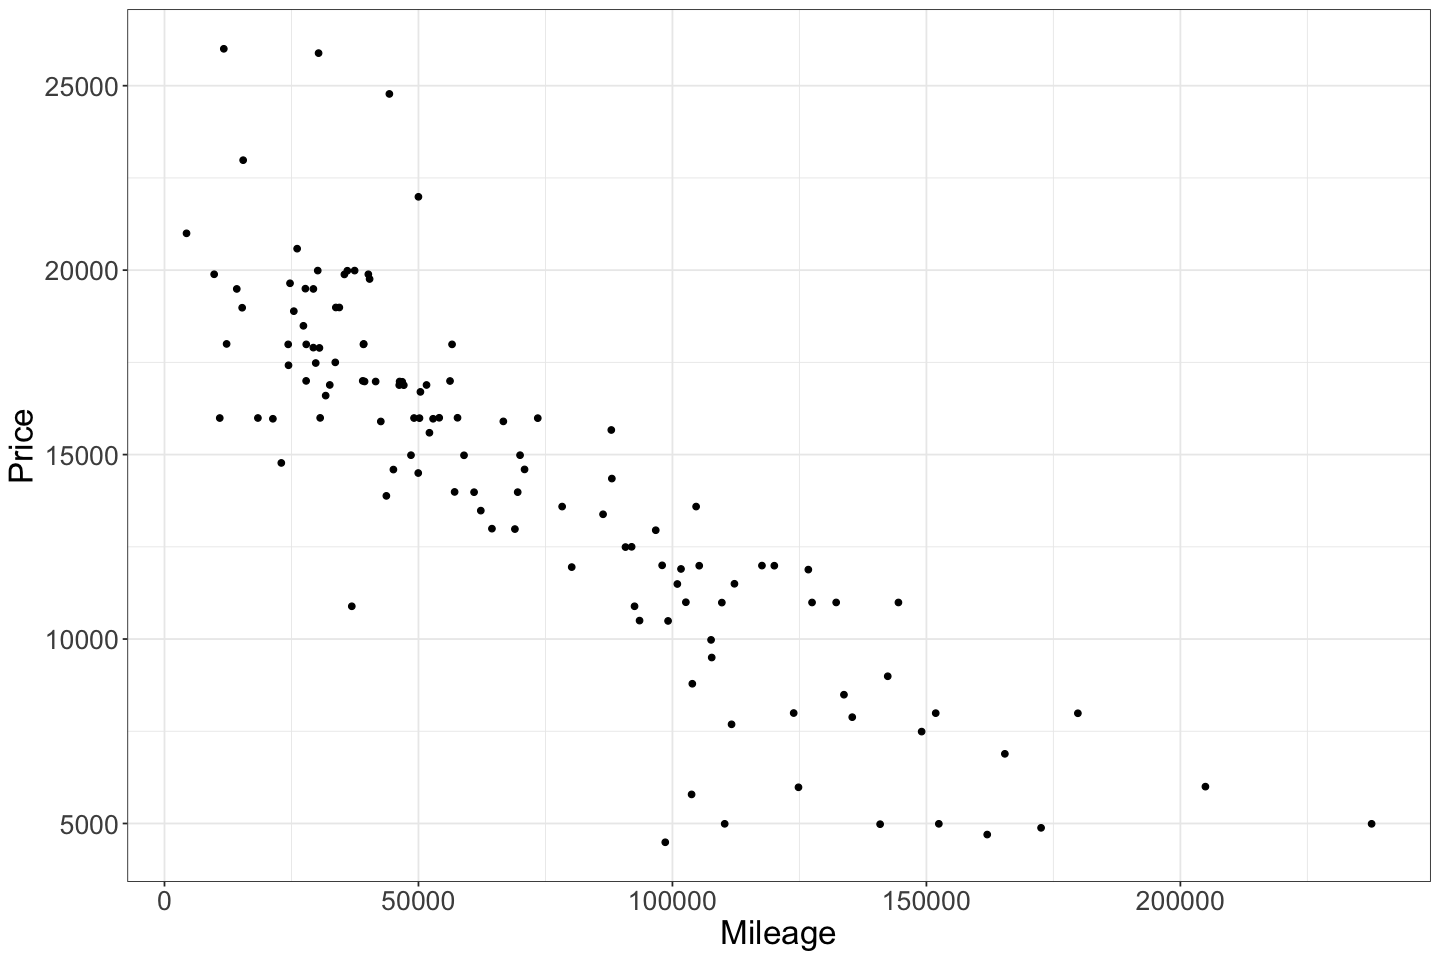

In [4]:
# Plot price as a function of mileage
ggplot(accords_data, aes(x = mileage, y = price)) +
  geom_point() +
  labs(x = "Mileage", y = "Price")

## Use Cross-Validation

Since the dataset is very small, makes more sense to use CV than to use held-out test set.

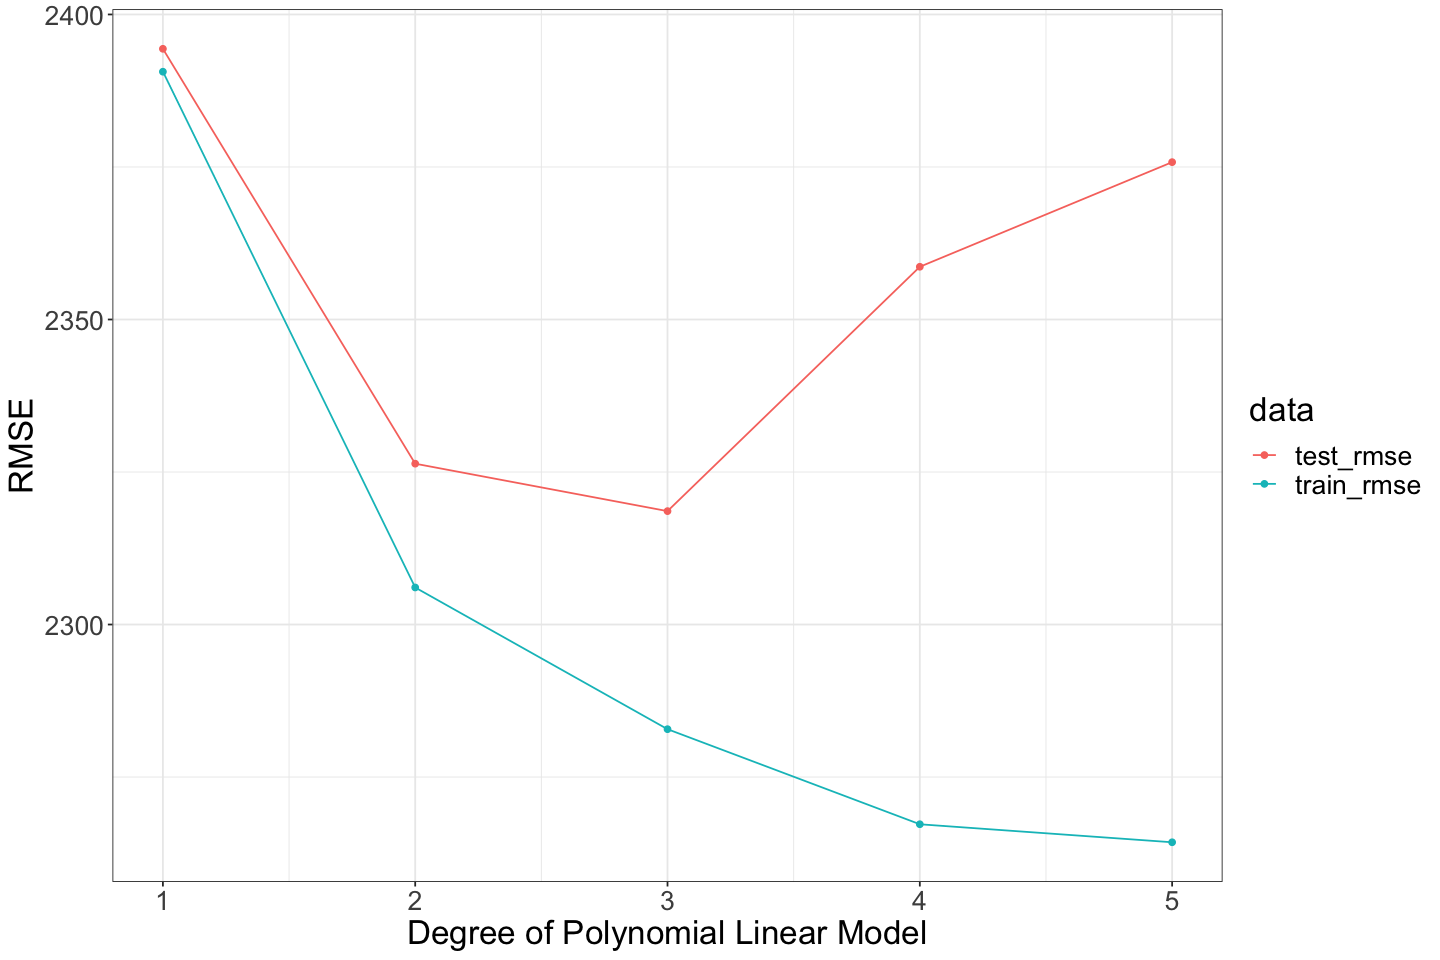

In [24]:
# Evaluate models using cross-validation
set.seed(10)
folds = 5
fold_size = nrow(accords_data) / folds
degrees = 1:5

train_rmses = numeric(length(degrees))
test_rmses = numeric(length(degrees))

for (degree in degrees) {
    fold_train_rmses = numeric(folds)
    fold_test_rmses = numeric(folds)

    for (fold in 1:folds) {
        test_indices = as.integer(1:fold_size + (fold - 1) * fold_size)
        train_data = accords_data[-test_indices, ]
        test_data = accords_data[test_indices, ]

        model = lm(price ~ poly(mileage, degree), data = train_data)
        train_predictions = predict(model, train_data)
        test_predictions = predict(model, test_data)

        train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
        test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

        fold_train_rmses[fold] = train_rmse
        fold_test_rmses[fold] = test_rmse
    }

    train_rmses[degree] = mean(fold_train_rmses)
    test_rmses[degree] = mean(fold_test_rmses)
}

errors = tibble(degree = degrees, train_rmse = train_rmses, test_rmse = test_rmses)
errors_long = gather(errors, "train_rmse", "test_rmse", key = "data", value = "rmse")

ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
  geom_line() +
  geom_point() +
  labs(x = "Degree of Polynomial Linear Model", y = "RMSE")

### Try Using a More Complex Model

A random forest is a more powerful machine learning model. Since it is more complex than a linear model, it is more likely to overfit!

<img src="img/rf.jpeg" alt= “spam-email” width="500" />

In [25]:
folds = 5
fold_size = nrow(accords_data) / folds

train_rmses = numeric(folds)
test_rmses = numeric(folds)

for (fold in 1:folds) {
    test_indices = as.integer(1:fold_size + (fold - 1) * fold_size)
    train_data = accords_data[-test_indices, ]
    test_data = accords_data[test_indices, ]

    rf = randomForest(price ~ mileage, data = train_data, ntree = 1000)

    train_predictions = predict(rf, train_data)
    test_predictions = predict(rf, test_data)

    train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
    test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

    train_rmses[fold] = train_rmse
    test_rmses[fold] = test_rmse
}

train_rmse = mean(train_rmses)
test_rmse = mean(test_rmses)

print(train_rmse)
print(test_rmse)

[1] 1354
[1] 2708


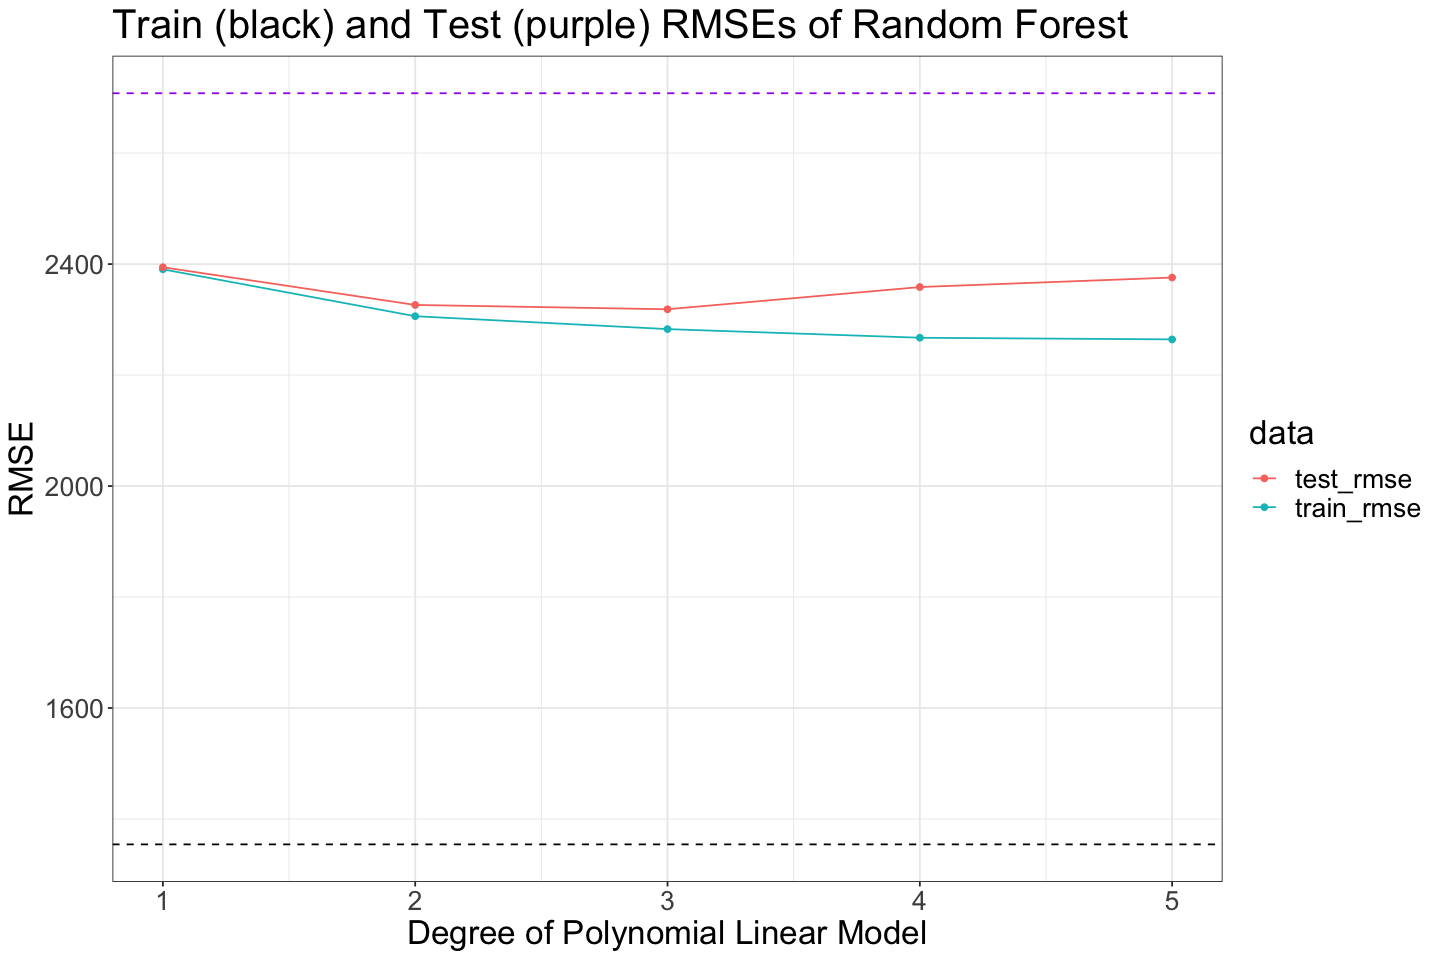

In [26]:
ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
    geom_line() +
    geom_point() +
    labs(x = "Degree of Polynomial Linear Model", y = "RMSE") + 
    # Add a horizontal line for the test RMSE of the random forest model
    geom_hline(yintercept = train_rmse, linetype = "dashed", color = "black") + 
    geom_hline(yintercept = test_rmse, linetype = "dashed", color = "purple") + 
    ggtitle("Train (black) and Test (purple) RMSEs of Random Forest")

### What changes if we use more data?

Let's use the entire cars dataset instead of just the accords data

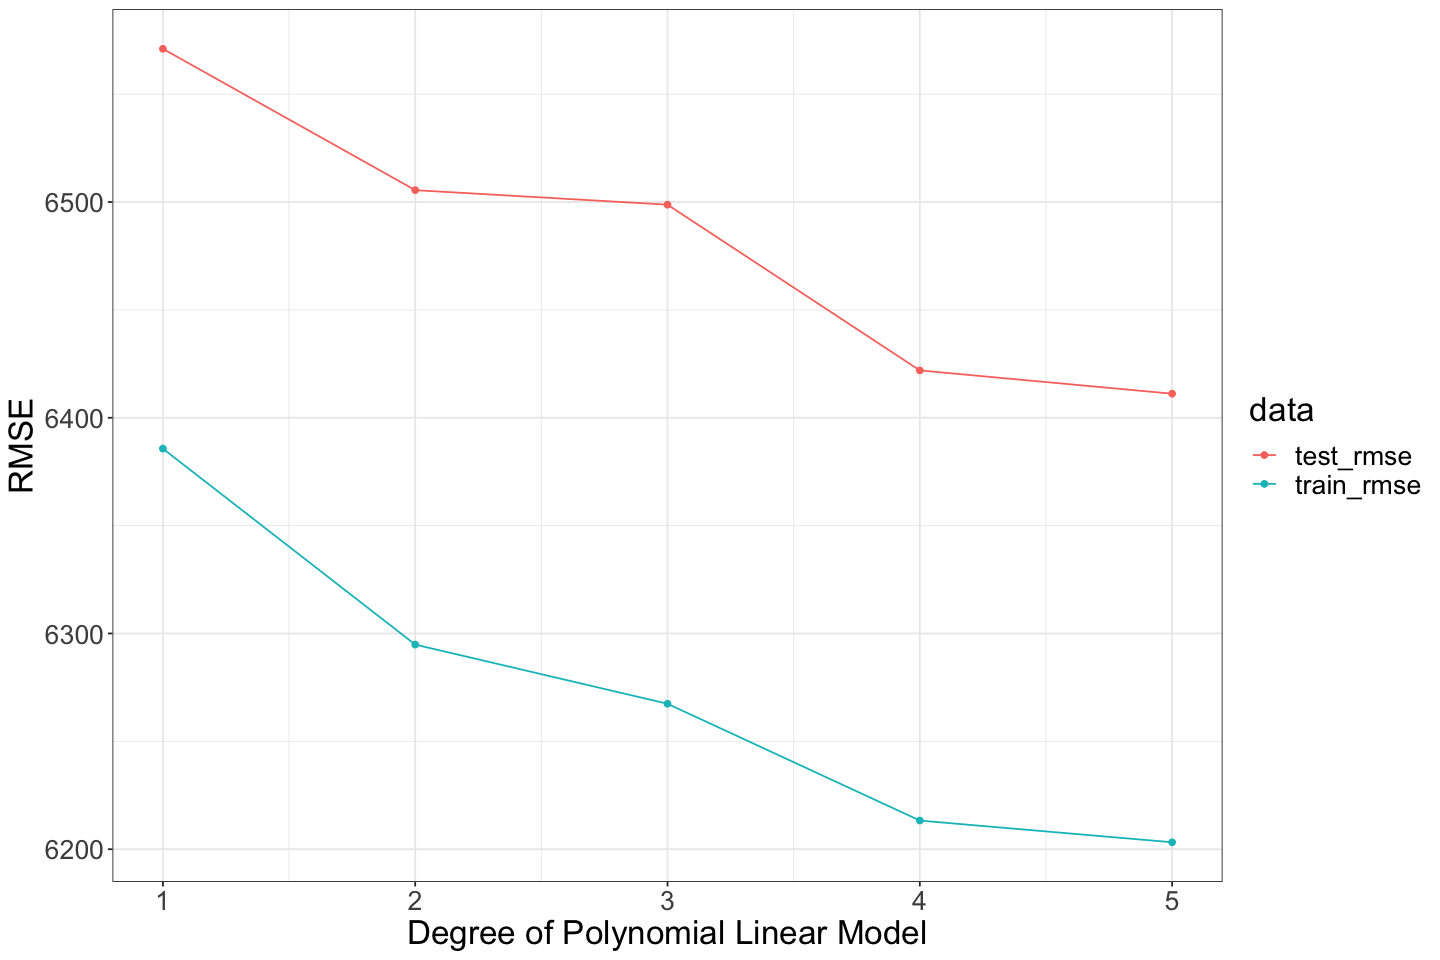

In [27]:
# Evaluate models using cross-validation
set.seed(10)
folds = 5
fold_size = nrow(cars_data) / folds
degrees = 1:5

train_rmses = numeric(length(degrees))
test_rmses = numeric(length(degrees))

for (degree in degrees) {
    fold_train_rmses = numeric(folds)
    fold_test_rmses = numeric(folds)

    for (fold in 1:folds) {
        test_indices = as.integer(1:fold_size + (fold - 1) * fold_size)
        train_data = cars_data[-test_indices, ]
        test_data = cars_data[test_indices, ]

        model = lm(price ~ poly(mileage, degree), data = train_data)
        train_predictions = predict(model, train_data)
        test_predictions = predict(model, test_data)

        train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
        test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

        fold_train_rmses[fold] = train_rmse
        fold_test_rmses[fold] = test_rmse
    }

    train_rmses[degree] = mean(fold_train_rmses)
    test_rmses[degree] = mean(fold_test_rmses)
}

errors = tibble(degree = degrees, train_rmse = train_rmses, test_rmse = test_rmses)
errors_long = gather(errors, "train_rmse", "test_rmse", key = "data", value = "rmse")

ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
  geom_line() +
  geom_point() +
  labs(x = "Degree of Polynomial Linear Model", y = "RMSE")

In [28]:
folds = 5
fold_size = nrow(cars_data) / folds

train_rmses = numeric(folds)
test_rmses = numeric(folds)

for (fold in 1:folds) {
    test_indices = as.integer(1:fold_size + (fold - 1) * fold_size)
    train_data = cars_data[-test_indices, ]
    test_data = cars_data[test_indices, ]

    rf = randomForest(price ~ mileage, data = train_data, ntree = 1000)

    train_predictions = predict(rf, train_data)
    test_predictions = predict(rf, test_data)

    train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
    test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

    train_rmses[fold] = train_rmse
    test_rmses[fold] = test_rmse
}

train_rmse = mean(train_rmses)
test_rmse = mean(test_rmses)

print(train_rmse)
print(test_rmse)

[1] 3521
[1] 7379


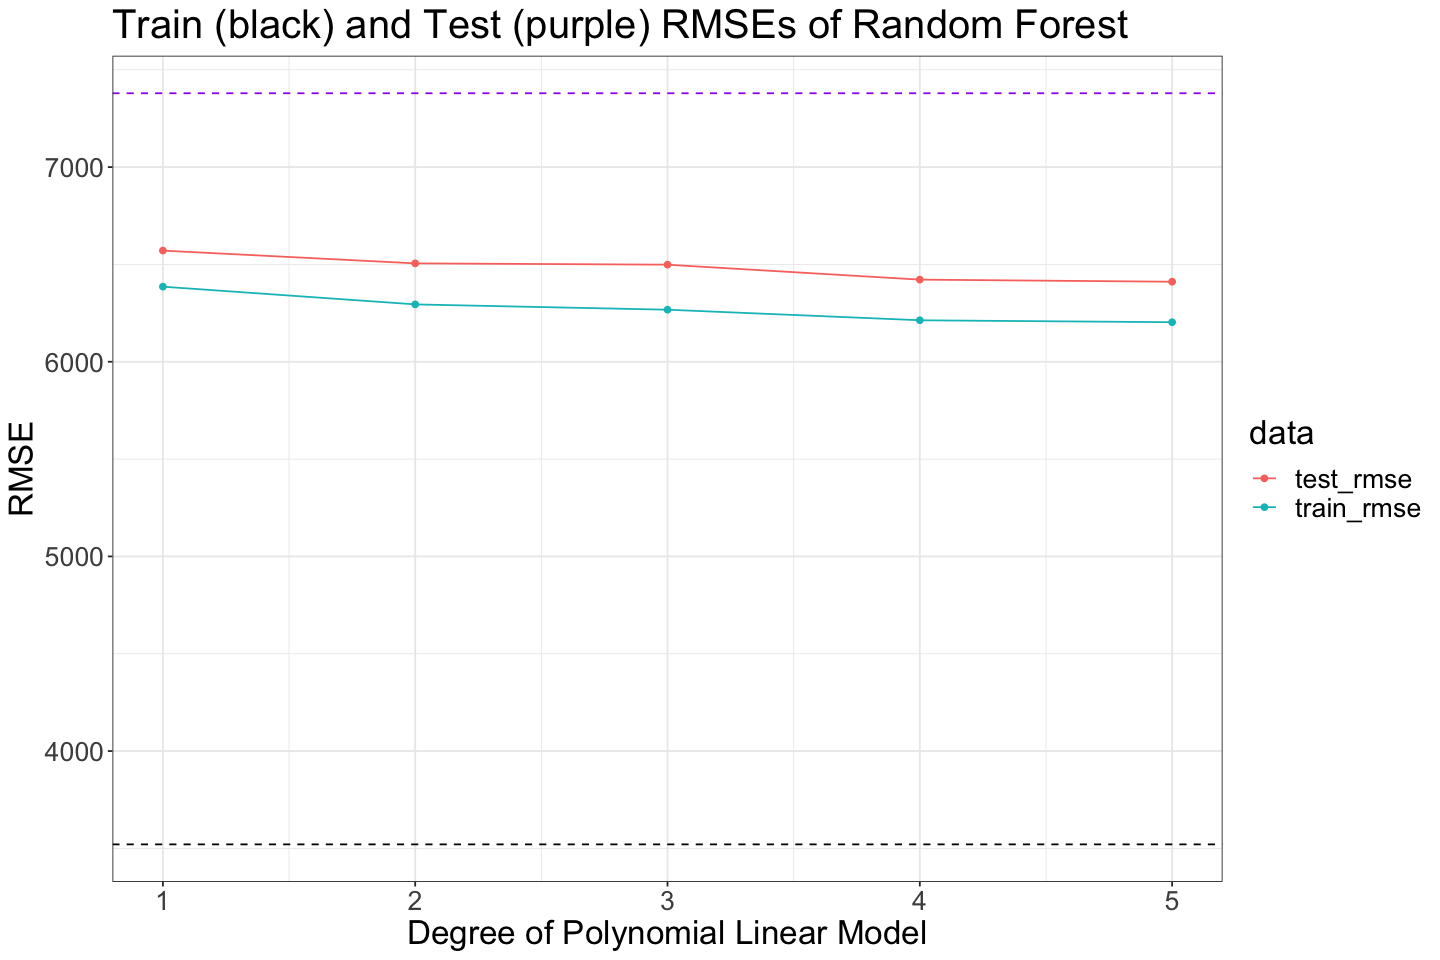

In [29]:
ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
    geom_line() +
    geom_point() +
    labs(x = "Degree of Polynomial Linear Model", y = "RMSE") + 
    # Add a horizontal line for the test RMSE of the random forest model
    geom_hline(yintercept = train_rmse, linetype = "dashed", color = "black") + 
    geom_hline(yintercept = test_rmse, linetype = "dashed", color = "purple") + 
    ggtitle("Train (black) and Test (purple) RMSEs of Random Forest")

#### Takeaway

Random Forest is still overfitting, but higher order polynomial models are not long overfitting!

If you want to use a more complex model, always check to make sure it is not overfitting!